# Classifying Audio using Spectrograms and CNNs

## Note on Data locations

I recommend putting the audio (WAV) and image (PNG) files in `data\audio` and `data\iamges` directories, respectively.

The `data\` directory is already included in the `.gitignore` file, and so these large binary files won't be included in commits.

### Example:

<img src="data_structure_example.png" style="widht:400px; height:auto;">

## Imports

In [65]:
import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from IPython.display import Audio
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

## AudioFile class

- `file_path`: Path to the audio file
- `file_name`: Name of the audio file (extracted from the path)
- `label`: Label of the audio file (derived from the parent directory name)
- `audio`: Loaded audio data
- `sample_rate`: Sampling rate of the audio file
- `duration`: Duration of the audio file in seconds

### Methods

- `display_waveform()`: Display the waveform of the audio file
- `play()`: Play the audio file and return an audio player widget
- `trim(top_db=30)`: Trim silent parts of the audio using a decibel threshold
- `create_spectrogram()`: Generate a mel spectrogram of the audio file
- `show_spectrogram()`: Display the spectrogram of the audio file
- `save_spectrogram(output_dir=None, skip_existing=True)`: Save the spectrogram as a PNG file


In [73]:
class AudioFile:
    """
    A class to handle audio files and provide utilities for analysis and visualization.

    Attributes:
        file_path (str): Path to the audio file.
        file_name (str): Name of the audio file (extracted from the path).
        label (str): Label of the audio file (derived from the parent directory name).
        audio (np.ndarray): Loaded audio data.
        sample_rate (int): Sampling rate of the audio file.
        duration (float): Duration of the audio file in seconds.
    """

    def __init__(self, file_path):
        """
        Initialize the AudioFile instance by loading the audio file and extracting metadata.

        Args:
            file_path (str): Path to the audio file.
        """
        self.file_path = file_path
        self.file_name = os.path.basename(file_path)
        self.label = os.path.basename(os.path.dirname(self.file_path))
        self.audio, self.sample_rate = librosa.load(file_path)
        self.duration = librosa.get_duration(y=self.audio, sr=self.sample_rate)

    def display_waveform(self):
        """
        Display the waveform of the audio file.
        """
        librosa.display.waveshow(self.audio, sr=self.sample_rate)
        plt.show()
        plt.close()

    def play(self):
        """
        Play the audio file.

        Returns:
            IPython.display.Audio: audio player widget.
        """
        return Audio(self.file_path)

    def trim(self, top_db=30):
        """
        Trim silent parts of the audio based on a decibel threshold.

        Args:
            top_db (int, optional): Decibel threshold below which audio is considered silent. Defaults to 30.
        """
        self.audio, _ = librosa.effects.trim(self.audio, top_db=top_db)

    def create_spectrogram(self):
        """
        Create a mel spectrogram of the audio file.

        Returns:
            np.ndarray: The mel spectrogram in decibel units.
        """
        mel_scale_sgram = librosa.feature.melspectrogram(y=self.audio, sr=self.sample_rate, power=1)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)
        return mel_sgram

    def show_spectrogram(self):
        """
        Display the spectrogram of the audio file.
        """
        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.show()
        plt.close()

    def save_spectrogram(self, output_dir=None, skip_existing=True):
        """
        Save the spectrogram as a PNG file.

        Args:
            output_dir (str, optional): Directory to save the spectrogram. Defaults to the directory of the audio file.
            skip_existing (bool, optional): Whether to skip saving if the file already exists. Defaults to True.
        """
        if not output_dir:
            output_dir = os.path.dirname(self.file_path)
        else:
            output_dir = os.path.join(output_dir, self.label)

        _base, _ = os.path.splitext(self.file_name)
        output_file = os.path.join(output_dir, _base + ".png")

        if skip_existing and os.path.exists(output_file):
            return

        _spectrogram = self.create_spectrogram()
        librosa.display.specshow(_spectrogram, sr=self.sample_rate)

        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_file)
        plt.close()


### Example of using AudioFile class

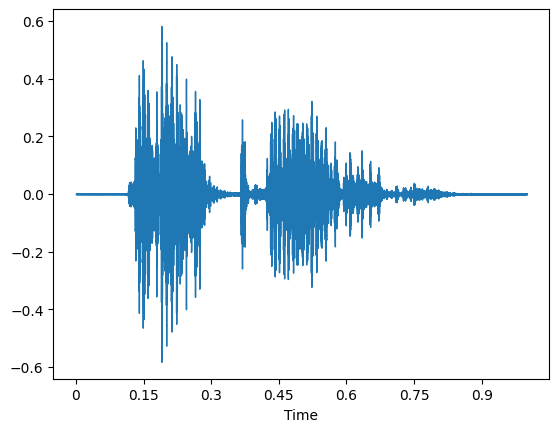

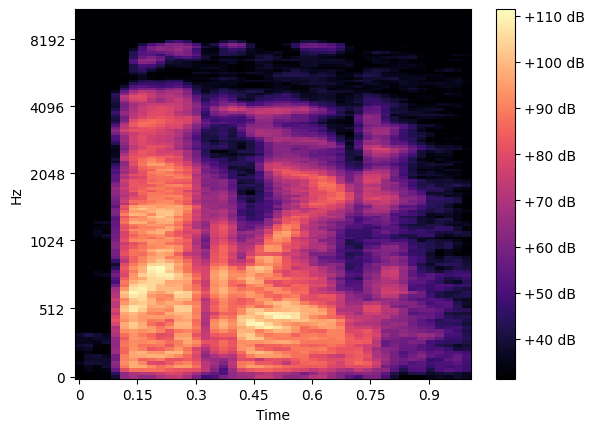

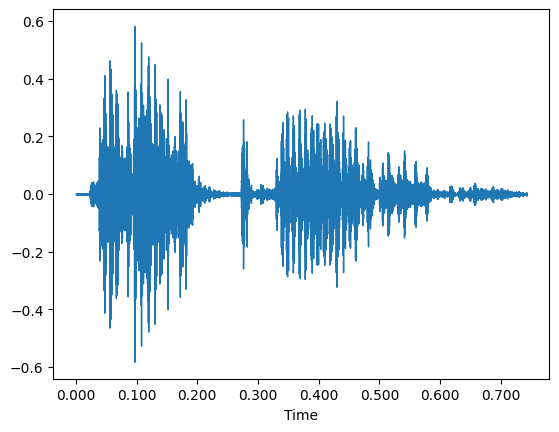

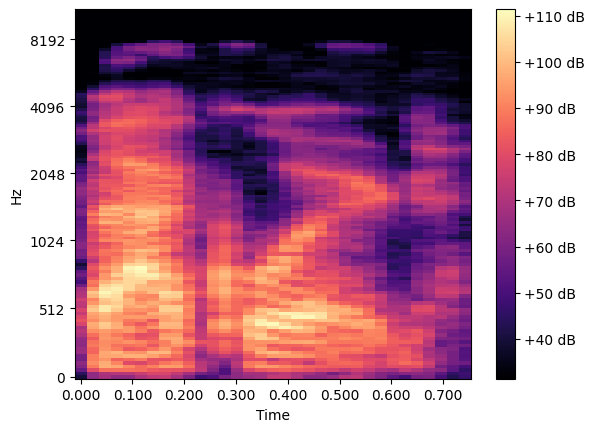

In [74]:
_audio_file = os.path.join("data", "audio", "Speech Commands", "backward", "0a2b400e_nohash_0.wav")
test_audio = AudioFile(_audio_file)

test_audio.display_waveform()
test_audio.show_spectrogram()
test_audio.trim()
test_audio.display_waveform()
test_audio.show_spectrogram()
test_audio.play()   # NOTE: play() has to be in its own cell or the last line; otherwise it doesn't show

## Convert Audio Files to Spectrograms

 - set input_dir and output_dir accordingly
 - call process_directory()
 - if skip_existing is True, existing spectrogram PNG files will be skipped (recommended)


### NOTE:

- Only run this cell if you need to save out all the spectrograms. It takes awhile, and is prone to crashing (hence the use of skip_existing, so it can continue where it left off).
- Commented out the "process_directory(...)" line at the bottom to avoid accidental runs

In [75]:
input_dir = os.path.join("data", "audio","Speech Commands")
output_dir = os.path.join("data", "images", "Speech Commands")

def process_directory(input_dir, output_dir, skip_existing=True):
    for root, dirs, files in os.walk(input_dir):
        # sort directories alphabetically
        dirs.sort()
        print(f"Processing directory: {os.path.basename(root)}")
        for file in files:
            if file.endswith('.wav'):
                # load file
                audio = AudioFile(os.path.join(root, file))
                # save spectrogram
                audio.save_spectrogram(output_dir, skip_existing=skip_existing)


# process_directory(input_dir, output_dir, skip_existing=True)

# Data Pipeline

In [76]:
# Define paths
data_folder='data/audio/Speech Commands'
pd.DataFrame(os.listdir(data_folder),columns=['Files'])

,Files
0,backward
1,bed
2,bird
3,cat
4,dog
5,down
6,eight
7,five
8,follow
9,forward


In [77]:
def count(path):
    size = []
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
    
file_counts = count(data_folder)
file_counts

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


## Create time series dataset

In [ ]:
def create_dataset(path):
    file_paths = []
    data = []
    label = []
    sample = []
    durations = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for fil in os.listdir(folder_path):
            file_path = os.path.join(folder_path,fil)
            audio_file = AudioFile(file_path)
            audio_data = audio_file.audio
            sample_rate = audio_file.sample_rate
            duration = audio_file.duration
            file_paths.append(file_path)
            data.append(audio_data)
            sample.append(sample_rate)
            label.append(folder)
            durations.append(duration)
    return data,file_paths,label,sample,durations

audio_data,file_paths,label,sample,durations = create_dataset(data_folder)
audio_df = pd.DataFrame()
audio_df['file_paths'], audio_df['Label'], audio_df['sample'], audio_df['duration'] = file_paths,label,sample,durations
audio_df

,file_paths,Label,sample,duration
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,22050,1.0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,22050,1.0
...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,22050,1.0


### Create numbered labels

In [10]:
numbered_labels = {}
start = 0
for i in pd.unique(audio_df.Label):
    numbered_labels[i] = start
    start += 1

pd.DataFrame(numbered_labels.values(),columns=['Value'],index=numbered_labels.keys())

,Value
backward,0
bed,1
bird,2
cat,3
dog,4
down,5
eight,6
five,7
follow,8
forward,9


### Label data with numbered labels

In [11]:
audio_df['Numbered Label'] = audio_df['Label'].apply(lambda x: numbered_labels[x]) 

audio_df

,file_paths,Label,sample,duration,Numbered Label
0,data/audio/Speech Commands\backward\0165e0e8_n...,backward,16000,1.0,0
1,data/audio/Speech Commands\backward\017c4098_n...,backward,16000,1.0,0
2,data/audio/Speech Commands\backward\017c4098_n...,backward,16000,1.0,0
3,data/audio/Speech Commands\backward\017c4098_n...,backward,16000,1.0,0
4,data/audio/Speech Commands\backward\017c4098_n...,backward,16000,1.0,0
...,...,...,...,...,...
105824,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,16000,1.0,34
105825,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,16000,1.0,34
105826,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,16000,1.0,34
105827,data/audio/Speech Commands\zero\ffd2ba2f_nohas...,zero,16000,1.0,34


In [ ]:
# Pad the arrays so they are all the same length
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data]

# Create array from list of data arrays
audio_data_arr = np.array(audio_data_padded)

## Exploratory Data Analysis

In [12]:
audio_df.shape

(105829, 5)

In [64]:
def count(path):
    size = []
    for file in os.listdir(path):
        size.append(len(os.listdir(os.path.join(path,file))))
    return pd.DataFrame(size,columns=['Number Of Sample'],index=os.listdir(path))  
    
file_counts = count(data_folder)
file_counts

,Number Of Sample
backward,1664
bed,2014
bird,2064
cat,2031
dog,2128
down,3917
eight,3787
five,4052
follow,1579
forward,1557


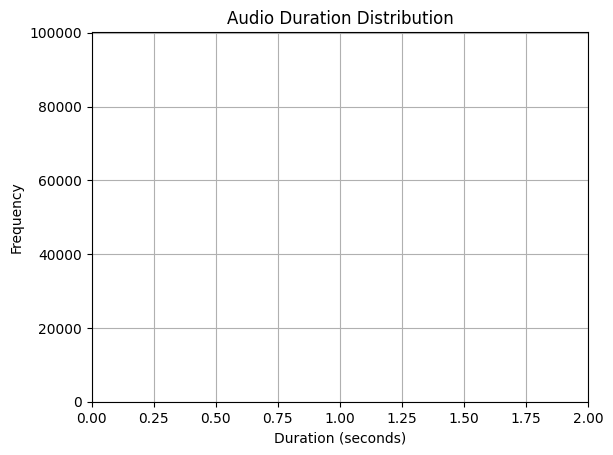

In [17]:
audio_df["duration"].hist(bins=10000)
plt.title("Audio Duration Distribution")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.xlim(0,2)
plt.show()

In [ ]:
# Find how the indeces for files that are less than 1 second
invalid_indices = [i for i, arr in enumerate(audio_data) if len(arr) != 22050]

# Print the # of files less than 1 second
print("# of files less than 1 second:", len(invalid_indices))

# Will put code for padding the data in the data pipeline section

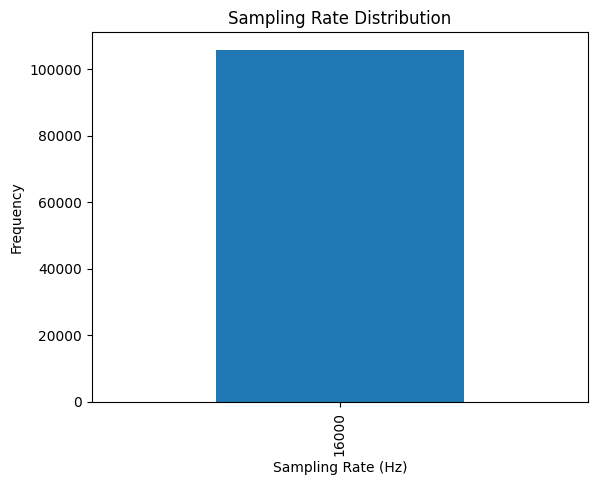

In [16]:
audio_df["sample"].value_counts().plot(kind="bar")
plt.title("Sampling Rate Distribution")
plt.xlabel("Sampling Rate (Hz)")
plt.ylabel("Frequency")
plt.show()

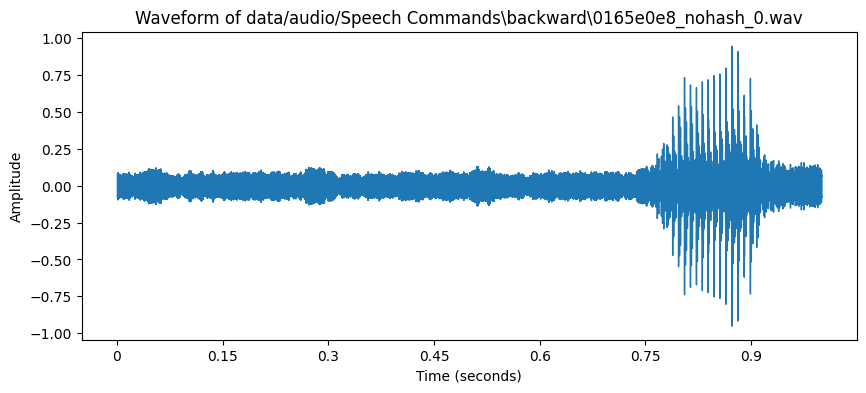

In [23]:
sample_data = audio_data[0]
sr = audio_df['sample'].iloc[0]
plt.figure(figsize=(10, 4))
librosa.display.waveshow(sample_data, sr=sr)
plt.title(f"Waveform of {audio_df['file_paths'].iloc[0]}")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()

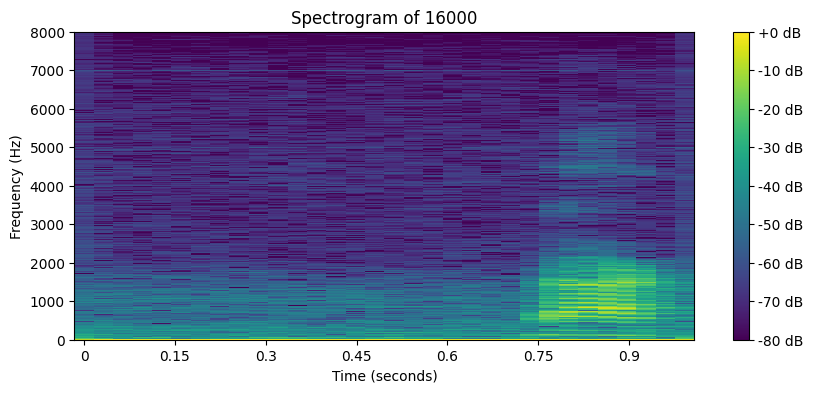

In [24]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis="time", y_axis="hz", cmap="viridis")
plt.title(f"Spectrogram of {audio_df['sample'].iloc[0]}")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

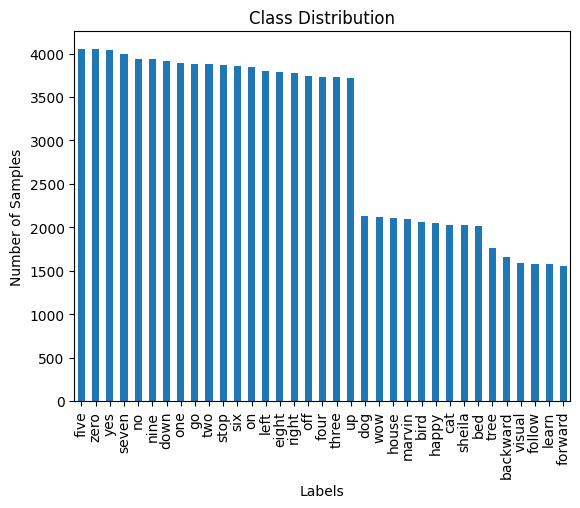

In [26]:
audio_df["Label"].value_counts().plot(kind="bar")
plt.title("Class Distribution")
plt.xlabel("Labels")
plt.ylabel("Number of Samples")
plt.show()

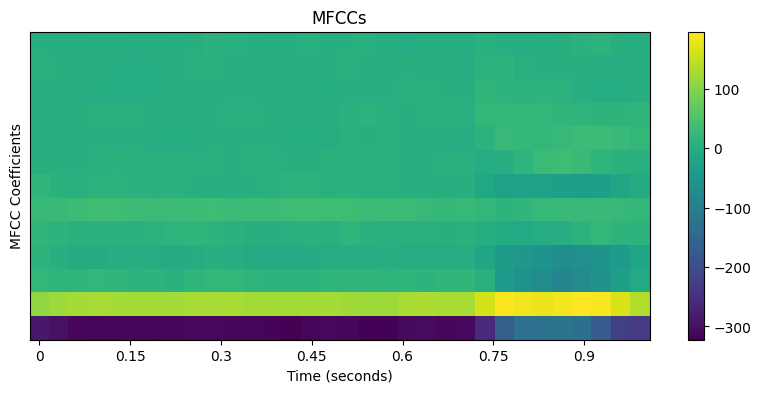

In [27]:
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, x_axis="time", cmap="viridis")
plt.title("MFCCs")
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.ylabel("MFCC Coefficients")
plt.show()

In [30]:
audio_df.iloc[0]

file_paths        data/audio/Speech Commands\backward\0165e0e8_n...
Label                                                      backward
sample                                                        16000
duration                                                        1.0
Numbered Label                                                    0
Name: 0, dtype: object

## Extracting pitch

In [31]:
## attempting with librosa normalization
sample_data = audio_data[300]
sr = audio_df['sample'].iloc[0]
f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
print(f0)

[245.00348838 191.28965042 192.18258202 190.86476432 184.43082788
 190.45773465 188.12537335 181.44821722 180.37329813 179.86952109
 182.70196426 185.48128436 182.97768928 140.07398207 449.86719711
 526.66810749 154.82050267 195.62748429 197.81733909 221.51370377
 789.78070655 802.06786653 138.2234039  139.20935701 139.54672239
 139.02778595 139.02855349  32.20786872 114.92419909 460.60295282
 463.16787879 112.67306976]


In [33]:
print(np.mean(f0))

244.7517211513328


In [38]:
## Functions to return pitch and average pitch of sample

def return_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return f0

def average_pitch(sample_num):
    sample_data = audio_data[sample_num]
    f0 = librosa.yin(sample_data, fmin=20, fmax=1000)
    return np.mean(f0)

In [39]:
return_pitch(550)

array([ 97.38366439,  23.10633746,  34.39860605,  69.99797919,
        68.26315448,  23.02283621,  34.26630963,  34.21437801,
        67.99918022,  68.9371673 ,  69.53454873,  66.70082509,
        67.32617406,  68.19660245,  68.34264743,  73.02795835,
       279.23741925, 266.07529255, 254.81241147, 265.03141888,
       293.931632  , 289.91317473, 285.55521425, 280.64307323,
       268.62668311,  69.98472694,  23.22529155,  34.98954841,
       352.51218718, 233.06287874, 226.89577758])

In [40]:
print(average_pitch(550))

140.6198419004171


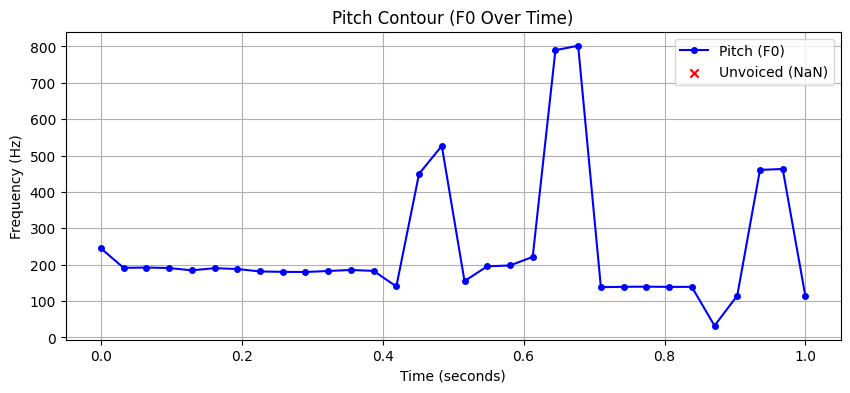

In [41]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

In [45]:
# trying different audio sample
sample_data2 = audio_data[60000]
f0 = librosa.yin(sample_data2, fmin=20, fmax=1000)
print(f0)
print(audio_df.iloc[60000])

[884.34793842 187.74935302 158.91557533 140.3966965   89.63043366
 521.60838511 220.35502175 168.90023112 165.95370929 163.64924697
 161.19664035 158.11652226 155.51492713 151.69223911 147.0233627
 147.49635804 151.24892607 166.4012276   23.04076632  37.00191017
  47.48611924  23.28148196  22.21608922  34.28213902 168.99884266
  37.77302953 222.97028541 112.91266774 107.60196704  81.88385193
  23.43760904  23.36055803]
file_paths        data/audio/Speech Commands\one\226537ab_nohash...
Label                                                           one
sample                                                        16000
duration                                                        1.0
Numbered Label                                                   21
Name: 60000, dtype: object


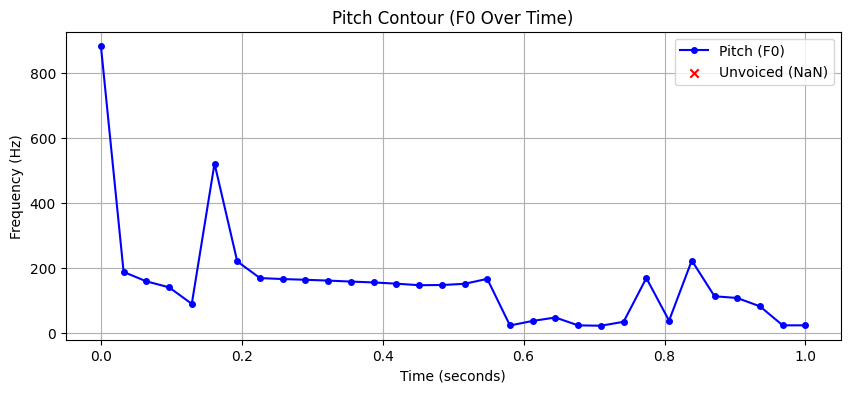

In [46]:
# Compute time axis for f0
times = np.linspace(0, len(sample_data2) / sr, num=len(f0))

# Plot the pitch contour
plt.figure(figsize=(10, 4))
plt.plot(times, f0, label="Pitch (F0)", color="blue", marker="o", markersize=4, linestyle="-")

# Mark unvoiced frames (NaN values in f0)
plt.scatter(times[np.isnan(f0)], np.zeros_like(times[np.isnan(f0)]), color='red', label="Unvoiced (NaN)", marker="x")

# Labels 
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.title("Pitch Contour (F0 Over Time)")
plt.legend()
plt.grid()
plt.show()

## Extracting pitch statistics across dataset

In [47]:
dataset_path = r"data\audio\Speech Commands"
# List to store pitch data
pitch_data = []

# Iterate through each word directory
for word in os.listdir(dataset_path):
    word_path = os.path.join(dataset_path, word)
    
    # Check if it's a directory (i.e., a class)
    if os.path.isdir(word_path):
        # Iterate through audio files in the word directory
        for file in os.listdir(word_path):
            if file.endswith(".wav"):
                file_path = os.path.join(word_path, file)
                
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)
                
                # Compute pitch (F0) using YIN
                # Can change fmin to lower value and fmax to higher value
                f0 = librosa.yin(y, fmin=50, fmax=500)

                # Remove NaNs (unvoiced regions)
                f0 = f0[~np.isnan(f0)]
                
                if len(f0) > 0:  # Only consider files where pitch was detected
                    pitch_data.append({
                        "word": word,
                        "file": file,
                        "mean_f0": np.mean(f0),
                        "median_f0": np.median(f0),
                        "std_f0": np.std(f0),
                        "min_f0": np.min(f0),
                        "max_f0": np.max(f0)
                    })

In [48]:
# Convert to Pandas DataFrame
pitch_df = pd.DataFrame(pitch_data)

# Save to CSV for further analysis
pitch_df.to_csv("pitch_statistics.csv", index=False)

# Display first few rows
print(pitch_df.head())

       word                   file     mean_f0   median_f0      std_f0  \
0  backward  0165e0e8_nohash_0.wav  137.148522   88.974426   81.460232   
1  backward  017c4098_nohash_0.wav  144.911786  119.826446  104.334736   
2  backward  017c4098_nohash_1.wav  141.948204  111.207695  109.615286   
3  backward  017c4098_nohash_2.wav  169.122299  118.557587  118.709701   
4  backward  017c4098_nohash_3.wav  154.573500  146.064696  104.684598   

      min_f0      max_f0  
0  61.079097  409.261369  
1  53.170360  447.479939  
2  50.763738  478.063368  
3  50.990918  501.136364  
4  53.892310  437.991516  


In [49]:
## Visualizing the pitch statistics

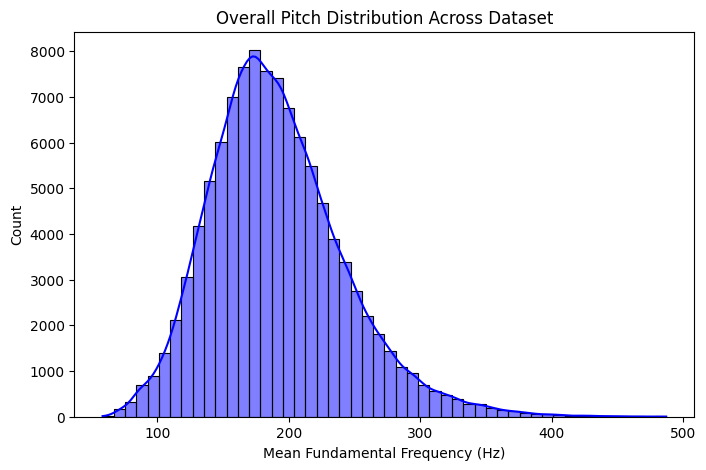

In [51]:
plt.figure(figsize=(8, 5))
sns.histplot(pitch_df["mean_f0"], bins=50, kde=True, color="blue")
plt.xlabel("Mean Fundamental Frequency (Hz)")
plt.ylabel("Count")
plt.title("Overall Pitch Distribution Across Dataset")
plt.show()

In general, the fundamental frequency of the complex speech tone – also known as the pitch or f0 – lies in the range of 100-120 Hz for men, but variations outside this range can occur. The f0 for women is found approximately one octave higher. For children, f0 is around 300 Hz.

https://www.dpamicrophones.com/mic-university/background-knowledge/facts-about-speech-intelligibility/#:~:text=In%20general%2C%20the%20fundamental%20frequency,f0%20is%20around%20300%20Hz.

Our dataset follows this general distrubtion of pitch 

In [52]:
## pitch distribution per word

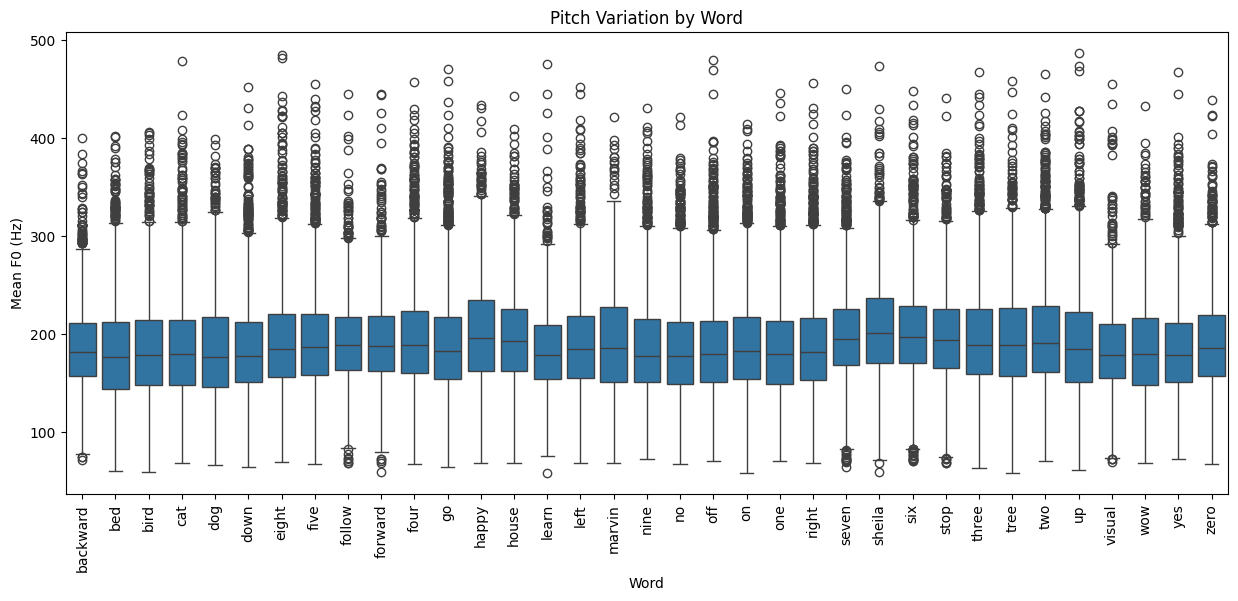

In [53]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=pitch_df, x="word", y="mean_f0")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Variation by Word")
plt.show()

In [54]:
## Density of Pitch per word

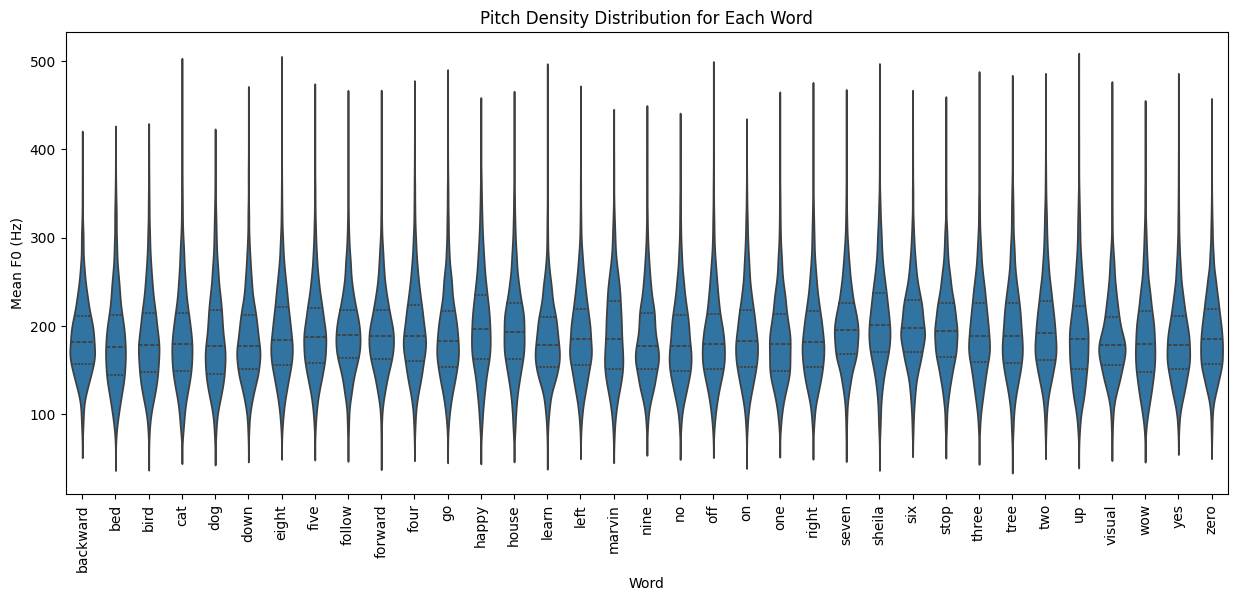

In [55]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=pitch_df, x="word", y="mean_f0", inner="quartile")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Mean F0 (Hz)")
plt.title("Pitch Density Distribution for Each Word")
plt.show()

C:\Users\Parker\AppData\Local\Temp\ipykernel_46864\234779674.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")


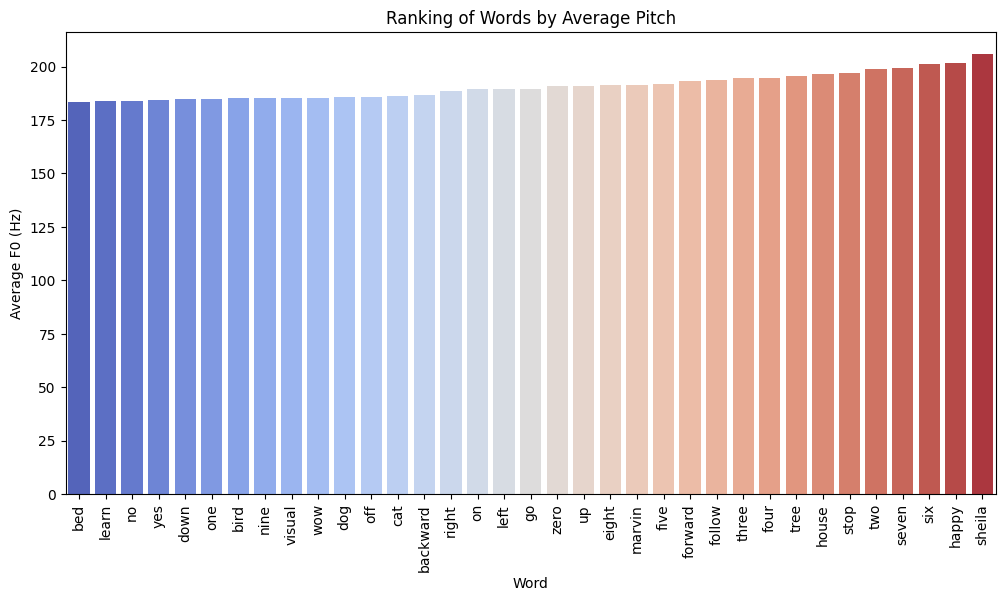

In [56]:
# Sort words by average pitch
word_avg_pitch = pitch_df.groupby("word")["mean_f0"].mean().sort_values()

# Make the plot
plt.figure(figsize=(12, 6))
sns.barplot(x=word_avg_pitch.index, y=word_avg_pitch.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Average F0 (Hz)")
plt.title("Ranking of Words by Average Pitch")
plt.show()

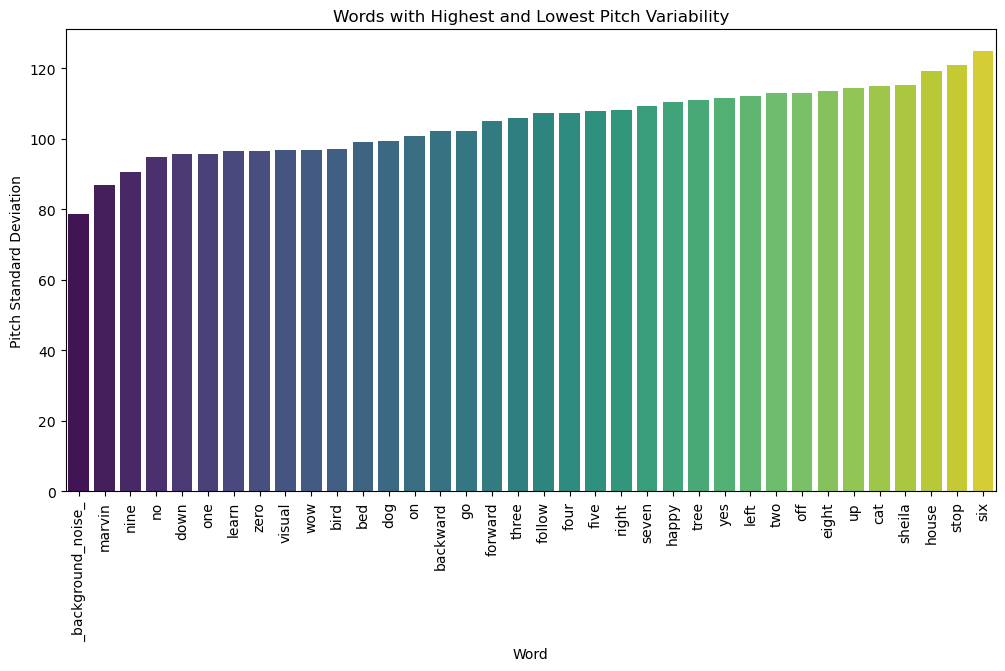

In [ ]:
word_std_pitch = pitch_df.groupby("word")["std_f0"].mean().sort_values()

plt.figure(figsize=(12, 6))
sns.barplot(x=word_std_pitch.index, y=word_std_pitch.values, palette="viridis")
plt.xticks(rotation=90)
plt.xlabel("Word")
plt.ylabel("Pitch Standard Deviation")
plt.title("Words with Highest and Lowest Pitch Variability")
plt.show()

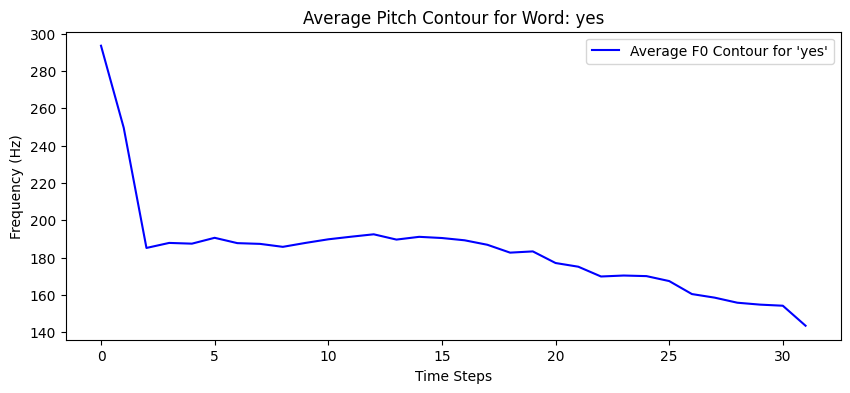

In [57]:
# word to analyze
target_word = "yes"

# Extract pitch sequences 
word_files = pitch_df[pitch_df["word"] == target_word]["file"]

all_f0_curves = []

for file in word_files:
    file_path = os.path.join(dataset_path, target_word, file)
    y, sr = librosa.load(file_path, sr=None)
    f0 = librosa.yin(y, fmin=50, fmax=500)
    f0 = f0[~np.isnan(f0)]  # Remove NaNs
    all_f0_curves.append(f0)

# Compute mean pitch contour
max_len = max(len(f) for f in all_f0_curves)
aligned_f0 = np.array([np.pad(f, (0, max_len - len(f)), mode='constant', constant_values=np.nan) for f in all_f0_curves])
mean_f0_contour = np.nanmean(aligned_f0, axis=0)

# Plot the mean pitch contour
plt.figure(figsize=(10, 4))
plt.plot(mean_f0_contour, label=f"Average F0 Contour for '{target_word}'", color="blue")
plt.xlabel("Time Steps")
plt.ylabel("Frequency (Hz)")
plt.title(f"Average Pitch Contour for Word: {target_word}")
plt.legend()
plt.show()


## Zero crossing rate

In [58]:
sample_data = audio_data[50000]
print(audio_df['file_paths'].iloc[50000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\no\879a2b38_nohash_2.wav


array([[0.02392578, 0.06884766, 0.13037109, 0.15283203, 0.14941406,
        0.12353516, 0.08154297, 0.06787109, 0.06787109, 0.0546875 ,
        0.04052734, 0.02441406, 0.02246094, 0.04296875, 0.05712891,
        0.07275391, 0.08349609, 0.07128906, 0.06396484, 0.05419922,
        0.04882812, 0.04492188, 0.04150391, 0.04980469, 0.05273438,
        0.05175781, 0.04833984, 0.04345703, 0.04248047, 0.04052734,
        0.03662109, 0.02197266]])

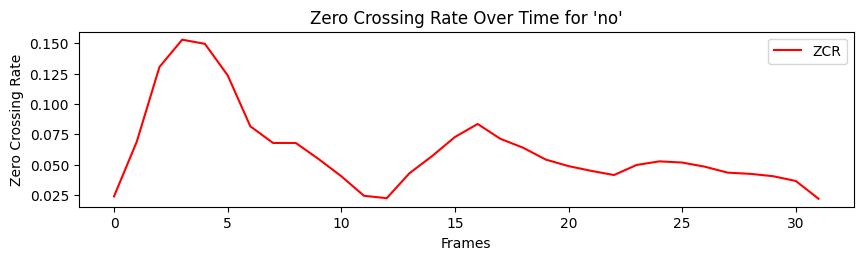

In [59]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'no'")
plt.legend()
plt.show()

In [61]:
sample_data = audio_data[70000]
print(audio_df['file_paths'].iloc[70000])

zcr = librosa.feature.zero_crossing_rate(sample_data)

zcr

data/audio/Speech Commands\seven\b7e9f841_nohash_0.wav


array([[0.16357422, 0.24951172, 0.28857422, 0.2421875 , 0.18945312,
        0.10449219, 0.12988281, 0.17285156, 0.26513672, 0.40429688,
        0.49853516, 0.60107422, 0.65820312, 0.69091797, 0.62353516,
        0.48876953, 0.36181641, 0.23828125, 0.1875    , 0.19287109,
        0.17041016, 0.15429688, 0.15380859, 0.140625  , 0.14697266,
        0.16699219, 0.18896484, 0.22265625, 0.21386719, 0.19482422,
        0.14257812, 0.07617188]])

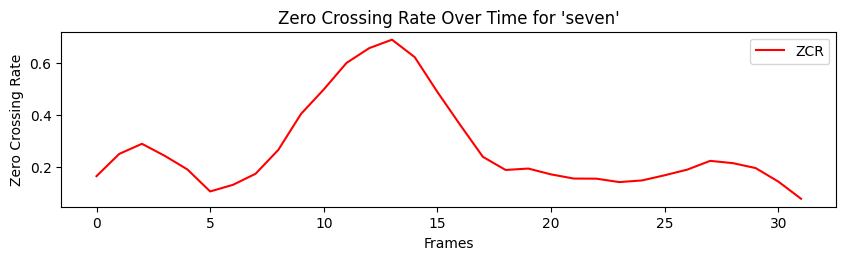

In [62]:
plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 2)
plt.plot(zcr[0], label="ZCR", color="red")
plt.xlabel("Frames")
plt.ylabel("Zero Crossing Rate")
plt.title("Zero Crossing Rate Over Time for 'seven'")
plt.legend()
plt.show()

In [104]:
audio_data_padded = [
    np.pad(arr, (0, 22050 - len(arr)), mode='constant', constant_values=0)
    for arr in audio_data
]

In [105]:
lengths = [len(arr) for arr in audio_data_padded]
for length in lengths:
    if length != 22050:
        print(length)

In [114]:
audio_data_arr = np.array(audio_data_padded)
type(audio_data_arr)

numpy.ndarray

In [116]:
inertia = []
K_range = range(1, 11)  # Test for k=1 to k=10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_data_arr)
    inertia.append(kmeans.inertia_)

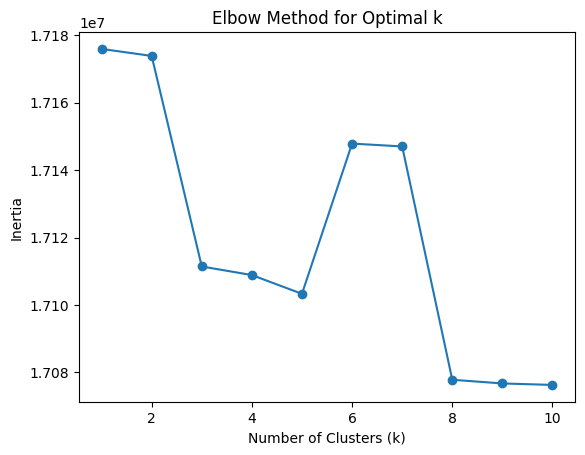

In [117]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

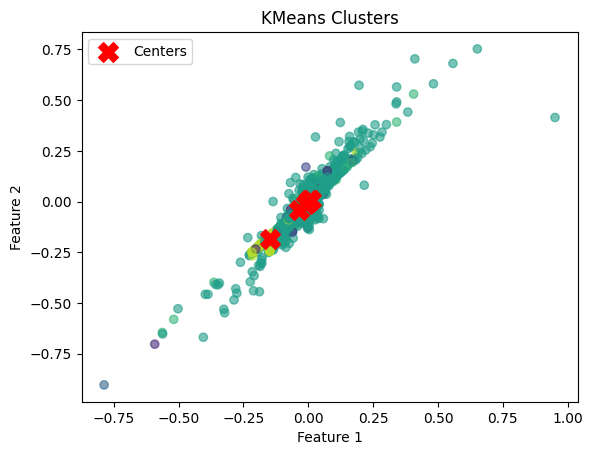

In [124]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_
plt.scatter(audio_data_arr[:, 0], audio_data_arr[:, 1], c=labels, cmap='viridis', alpha=0.6)
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, marker='X', label="Centers")
plt.title("KMeans Clusters")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

In [125]:
audio_data_arr[0]

array([-0.06210037, -0.07466451, -0.0687933 , ..., -0.07080275,
       -0.08166929, -0.0516717 ], dtype=float32)

In [127]:
all_mfcc_features = []
for data in audio_data_padded:
    mfcc = librosa.feature.mfcc(y=data, sr=22050, n_mfcc=13)
    all_mfcc_features.append(mfcc.T)
    
all_mfcc_features = np.vstack(all_mfcc_features)
print("Combined MFCC Features Shape:", all_mfcc_features.shape)

Combined MFCC Features Shape: (4656476, 13)


In [137]:
inertia = []
K_range = range(55, 105, 10)  

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(audio_data_arr)
    inertia.append(kmeans.inertia_)
    print(f'kmeans done with clusters {k}')

kmeans done with clusters 55


KeyboardInterrupt: 

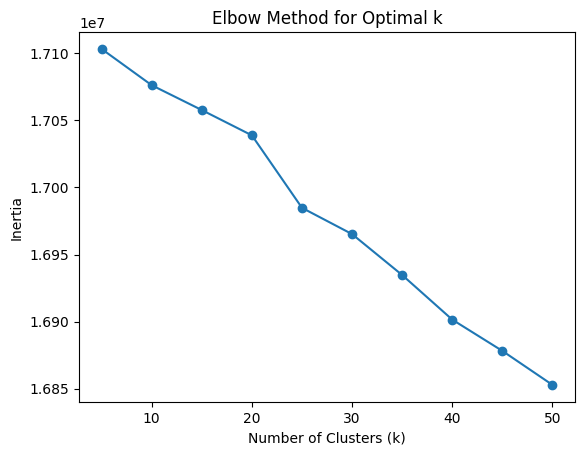

In [134]:
plt.plot(K_range, inertia, marker='o', linestyle='-')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
mfcc_reduced = pca.fit_transform(all_mfcc_features)

# Plot the clusters
plt.scatter(mfcc_reduced[:, 0], mfcc_reduced[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.title("KMeans Clusters of MFCCs")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()